## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


# Camera calibration using chessboard images
save the camera calibration parameters into a binary file.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
import os
import errno

# create directory
def mkdir(path):
    try:
        os.makedirs(path)
    except OSError as e:
        if e.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

# create directory and file path
save_directory = '../calibration_data/'
save_file_name = 'calibration_points_pickle.p'
file_path = save_directory + save_file_name
mkdir(save_directory)

# save camera calibration parameters
def saveCaliborationParameters():

    # prepare object points
    objectPoint = np.zeros((6*9,3), np.float32)
    objectPoint[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

    # arrays to store object points and images points
    objectPoints = []
    imagePoints =[]

    # make a list of calibration images
    images = glob.glob('../camera_cal/calibration*.jpg')

    # search cheseboard corners
    for index, fileName in enumerate(images):
        image = cv2.imread(fileName)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # find corners in cheseboard
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
        if ret == True:
            objectPoints.append(objectPoint)
            imagePoints.append(corners)

            # # draw and display the corners
            # imageWithCorners = cv2.drawCheseboardCorners(img, (9,6), corners, ret)
            # cv2.imshow(imageWithCorners)
            # cv2.waitKey(500)

    cv2.destroyAllWindows()

    # save objectPoints and imagePoints into pickle
    dist_pickle = {}
    image = cv2.imread('../camera_cal/calibration1.jpg')
    image_size = (image.shape[1], image.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objectPoints, imagePoints, image_size, None, None)
    dist_pickle['mtx'] = mtx
    dist_pickle['dist'] = dist

    file_path = os.path.join(save_directory, save_file_name)
    pickle.dump(dist_pickle, open(file_path, 'wb'))


# save corners points
saveCaliborationParameters()

# read saved parameters
dist_pickle = pickle.load(open(file_path, 'rb'))
mtx = dist_pickle['mtx']
dist = dist_pickle['dist']


# Calibration distort images

In [2]:
def calibration_undistort(image):
    image_size = (image.shape[1], image.shape[0])
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    undistort = cv2.undistort(image, mtx, dist, None, mtx)
    return undistort

## Test Calibration on cheseboard image

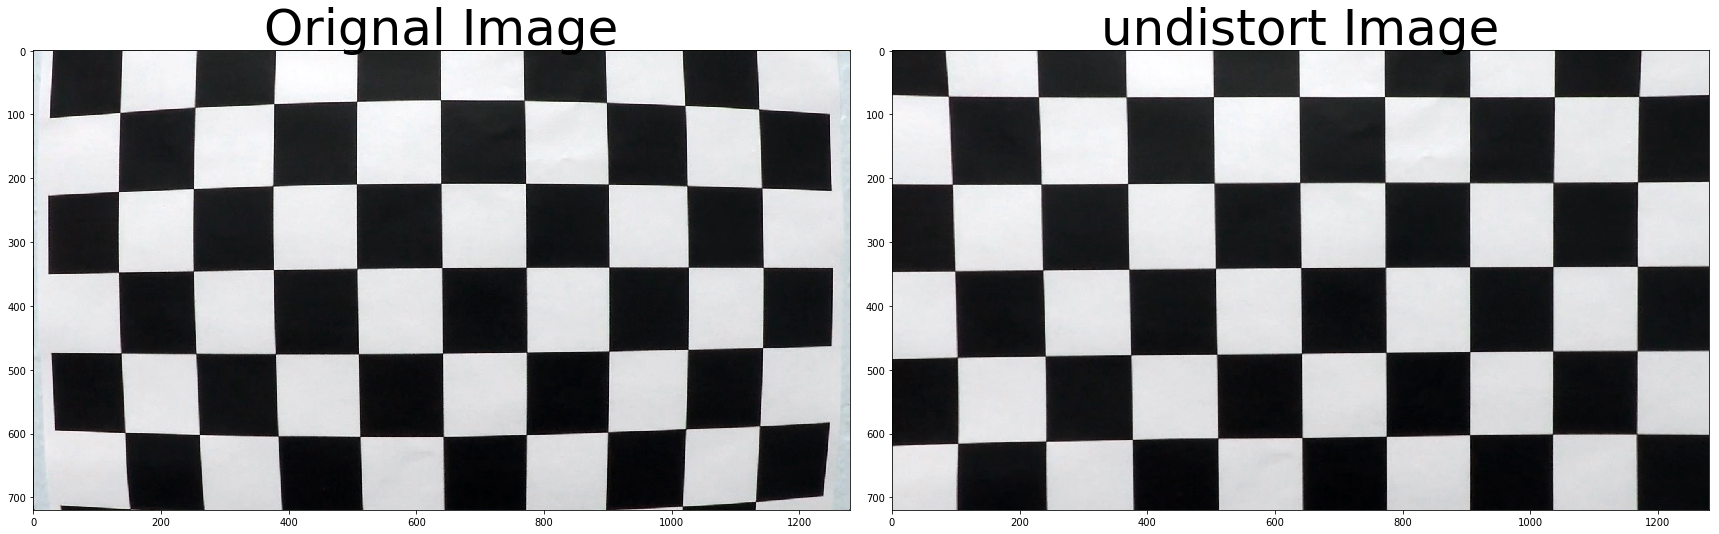

In [20]:
# output images directory
output_path = '../output_images/'

# undistort example cheseboard image
def testCalibration(image):
    undistort_image = calibration_undistort(image)

    f,(ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Orignal Image', fontsize=50)
    ax2.imshow(undistort_image)
    ax2.set_title('undistort Image', fontsize=50)
    plt.savefig(output_path + 'distort_image.jpg')

# test calibration
image_calibration = cv2.imread('../camera_cal/calibration1.jpg')
testCalibration(image_calibration)

# Test Calibration on road image

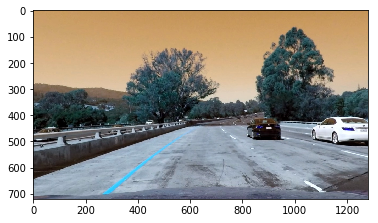

In [21]:
# test calibration on road images
image_calibration_road = cv2.imread('../test_images/test1.jpg')
undistort_image = calibration_undistort(image_calibration_road)
plt.imshow(undistort_image)
plt.savefig(output_path + 'distort_image2.jpg')

# Image perspective transform

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
%matplotlib inline

source_points = np.float32([[245, 690],[596, 450], [685, 450], [1068, 690]])
dest_points = np.float32([[240, 700], [240, 0], [970, 0], [970, 700]])

def warpImage(image):
    image_size = (image.shape[1], image.shape[0])
    minV = cv2.getPerspectiveTransform(dest_points, source_points)
    M = cv2.getPerspectiveTransform(source_points, dest_points)
    warped = cv2.warpPerspective(image, M, image_size, flags=cv2.INTER_LINEAR)
    return (warped, minV)

# Test Transform on road images

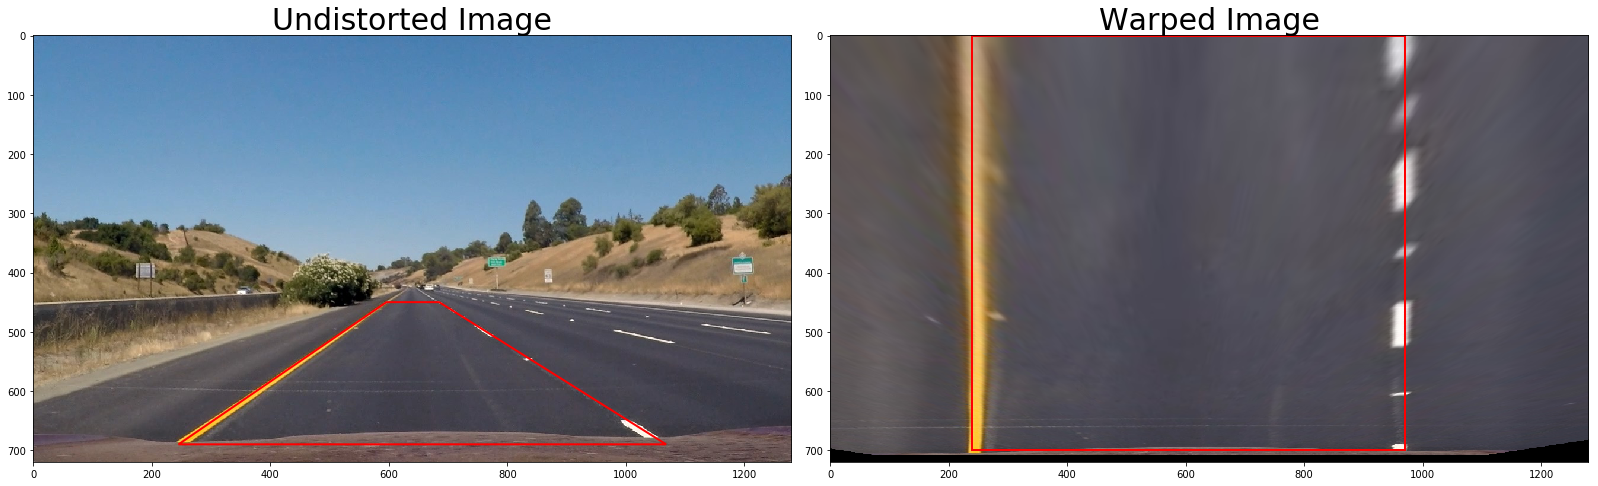

In [5]:
image_straight_lines = mpimg.imread('../test_images/straight_lines1.jpg')

undistort_image = calibration_undistort(image_straight_lines)
warped_image, minV = warpImage(undistort_image)

# draw distort and warped image
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image_straight_lines)
ax1.add_patch(patches.Polygon(xy=source_points, fill=False, color='r', linewidth=2))
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(warped_image)
ax2.add_patch(patches.Polygon(xy=dest_points, fill=False, color='r', linewidth=2))
ax2.set_title('Warped Image', fontsize=30)
plt.subplots_adjust(left=0.05, right=0.95, top=0.9, bottom=0.1)
plt.savefig(output_path + 'warped_stright_line.jpg')


# Gradient threshhold methods

In [6]:
# sobel gradient method
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, sobel_kernel))
    elif orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, sobel_kernel))
    else:
        raise
    sobel_binary = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(sobel_binary)
    binary_output[(sobel_binary >= thresh[0]) & (sobel_binary <= thresh[1])] = 1
    return binary_output

# sobel magitude method
def mag_sobel_thresh(img, sobel_kernel=3, thresh=(0,255)):
    abs_sobel_x = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, sobel_kernel))
    abs_sobel_y = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, sobel_kernel))
    mag_sobel = np.sqrt(abs_sobel_x**2 + abs_sobel_y**2)
    mag_sobel_binary = np.uint8(255*mag_sobel/np.max(mag_sobel))
    sobel_binary = np.zeros_like(mag_sobel_binary)
    sobel_binary[(mag_sobel_binary >= thresh[0]) & (mag_sobel_binary <= thresh[1])] = 1
    return sobel_binary

# sobel direction method
def dir_sobel_thresh(img, sobel_kernel=3, thresh=(0,np.pi/2)):
    abs_sobel_x = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, sobel_kernel))
    abs_sobel_y = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, sobel_kernel))
    sobel_direction = np.arctan2(abs_sobel_y, abs_sobel_x)
    sobel_binary = np.zeros_like(sobel_direction)
    sobel_binary[(sobel_direction >= thresh[0]) & (sobel_direction <= thresh[1])] = 1
    return sobel_binary

# check HLS channel threshold method
def channel_thresh(img, channel = 's', thresh=(0,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if channel == 's':
        check_channel = hls[:,:,2]
    elif channel == 'h':
        check_channel = hls[:,:,0]
    elif channel == 'l':
        check_channel == hls[:,:,1]
    s_binary = np.zeros_like(check_channel)
    s_binary[(check_channel >= thresh[0]) & (check_channel <= thresh[1])] = 1
    return s_binary

# combined multiple sobel gradient methods 
def combined_thresh(img):
    image_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobel_gradient_x = abs_sobel_thresh(image_gray, orient='x', sobel_kernel=3, thresh=(90,255))
    sobel_gradient_y = abs_sobel_thresh(image_gray, orient='y', sobel_kernel=3, thresh=(90,255))
    sobel_gradient_mag = mag_sobel_thresh(image_gray, sobel_kernel=3, thresh=(90, 255))
    sobel_gradient_dir = dir_sobel_thresh(image_gray, sobel_kernel=3, thresh=(np.pi/8, np.pi/2))

    binary_chanel_s = channel_thresh(img, channel = 's', thresh=(170, 255))

    combined_binary = np.zeros_like(sobel_gradient_dir)
    combined_binary[((sobel_gradient_x==1) & (sobel_gradient_y==1))|((sobel_gradient_mag==1) & (sobel_gradient_dir==1))|(binary_chanel_s==1)] = 1
    return combined_binary

# Test combined threshold method

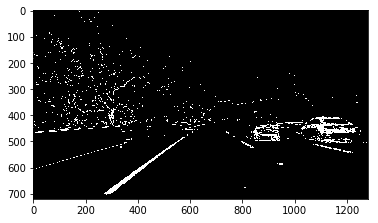

In [7]:
# # draw binary combined image for test road image
image_test = mpimg.imread('../test_images/test6.jpg')
image_undistort = calibration_undistort(image_test)
binary_image = combined_thresh(image_undistort)
plt.imshow(binary_image, cmap='gray')
plt.savefig(output_path + 'binary_combined_image.jpg')

# Define Line class to track line information

In [8]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None   
        #polynomial average coefficients of the last n iterations
        self.best_fit = None
        #polynomial coefficients of the last n iterations
        self.recent_fits = []  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None
        #y values for detected line pixels
        self.ally = None

# Implement Sliding Windows and Fit a Polynomial

In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# Method to detect lanes on the first frame of the video
def init_frame(binary_warped):
    left_line = Line()
    right_line = Line()
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    out_img = out_img.astype(np.uint8)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(np.int(histogram.shape[0]/2))
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # update lines properties
    left_line.current_fit = left_fit
    right_line.current_fit = right_fit

    left_line.best_fit = left_fit
    right_line.best_fit = right_fit

    left_line.recent_fits.append(left_fit)
    left_line.recent_fits.append(right_fit)

    left_line.allx = left_fitx
    right_line.allx = right_fitx
    
    left_line.recent_xfitted.append(left_fitx)
    right_line.recent_xfitted.append(right_fitx)

    left_line.bestx = left_fitx
    right_line.bestx = right_fitx

    return (out_img, left_line, right_line, left_lane_inds, right_lane_inds)


# Test lane polynomial detection on road images

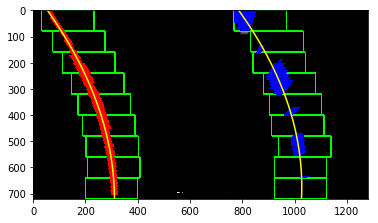

In [10]:
def draw_polynomials(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds): 
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.savefig(output_path + 'color_fit_line.jpg')

image_test = mpimg.imread('../test_images/test2.jpg')
# undistort image
image_undistort = calibration_undistort(image_test)
# convert to binary image using combined threshold
binary_image = combined_thresh(image_undistort)
# transform perspective of the image
warped_image, minV = warpImage(binary_image)
out_img, left_line, right_line, left_lane_inds, right_lane_inds = init_frame(warped_image.copy())
draw_polynomials(warped_image.copy(), left_line.current_fit, right_line.current_fit, left_lane_inds, right_lane_inds)
    

# Lane detection on each frame after first frame

In [11]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
SMOTH_CONSTANCE_STEPS = 10

# method to process each frame
# return detected left and right lane object
def processing_frame(binary_warped, previous_left_line, previous_right_line):
    left_line = Line()
    right_line = Line()
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (previous_left_line.current_fit[0]*(nonzeroy**2) + \
                     previous_left_line.current_fit[1]*nonzeroy + previous_left_line.current_fit[2] \
                     - margin)) & (nonzerox < (previous_left_line.current_fit[0]*(nonzeroy**2) + \
                     previous_left_line.current_fit[1]*nonzeroy + previous_left_line.current_fit[2] + margin)))

    right_lane_inds = ((nonzerox > (previous_right_line.current_fit[0]*(nonzeroy**2) + \
                      previous_right_line.current_fit[1]*nonzeroy + previous_right_line.current_fit[2] \
                      - margin)) & (nonzerox < (previous_right_line.current_fit[0]*(nonzeroy**2) + \
                      previous_right_line.current_fit[1]*nonzeroy + previous_right_line.current_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]

    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    if len(leftx) == 0 or len(rightx) == 0:
        return (previous_left_line, previous_right_line)

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    left_line.current_fit = left_fit
    right_fit = np.polyfit(righty, rightx, 2)
    right_line.current_fit = right_fit

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    left_line.allx = left_fitx
    right_line.allx = right_fitx
    # Caculate curvature
    y_eval = np.max(ploty)

    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    left_line.radius_of_curvature = left_curverad
    right_line.radius_of_curvature = right_curverad

    vehicle_center_pixel = binary_warped.shape[1]/2
    ploty_max = np.max(ploty)
    left_bottom_x = left_fitx = left_fit[0]*ploty_max**2 + left_fit[1]*ploty_max + left_fit[2]
    right_bottom_x = right_fit[0]*ploty_max**2 + right_fit[1]*ploty_max + right_fit[2]

    left_line.line_base_pos = (vehicle_center_pixel - left_bottom_x) * xm_per_pix
    right_line.line_base_pos = (right_bottom_x - vehicle_center_pixel) * xm_per_pix

    return (left_line, right_line)

# Draw lane section and write text methods

In [12]:
def draw_lanes_section(binary_warped, left_line, right_line):
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    pts_left = np.array([np.transpose(np.vstack([left_line.allx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line.allx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    return color_warp

def draw_into_original_image(image_undistort, color_warp, minV, image_size):
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, minV, image_size) 
    # Combine the result with the original image
    result = cv2.addWeighted(image_undistort, 1, newwarp, 0.3, 0)
    return result

def write_text(result_image, current_left_line, current_right_line):
    font = cv2.FONT_HERSHEY_SIMPLEX
    curvature_left_text = "Left Curvature:" + format(current_left_line.radius_of_curvature, '.2f') + "    "
    to_left_text = "To Left:" + format(current_left_line.line_base_pos, '.2f')
    curvature_right_text = "Right Curvature:" + format(current_right_line.radius_of_curvature, '.2f') + "  "
    to_right_text = "To Right:" + format(current_right_line.line_base_pos, '.2f')
    cv2.putText(result_image, curvature_left_text + to_left_text, (10,100), font, 2, (255,255,255))
    cv2.putText(result_image, curvature_right_text + to_right_text, (10,200), font, 2, (255,255,255))
    return result_image

# Smoth line detection result 

In [13]:
def smoth_sanity_check(previous_line, current_line):
    current_line.recent_xfitted = previous_line.recent_xfitted.copy()
    current_line.recent_fits = previous_line.recent_fits.copy()
    if len(current_line.recent_xfitted) >= SMOTH_CONSTANCE_STEPS:
        current_line.recent_xfitted.pop(0)
    if len(current_line.recent_fits) >= SMOTH_CONSTANCE_STEPS:
        current_line.recent_fits.pop(0)

    # Abandoned radius of curature which less than 300
    if current_line.radius_of_curvature > 300:
        current_line.recent_fits.append(current_line.current_fit)
        current_line.best_fit = apply_filter(current_line.recent_fits)
    else:
        current_line.current_fit = previous_line.best_fit
        current_line.best_fit = previous_line.best_fit
    # Check if line to vehcile center distance is reasonable
    if current_line.line_base_pos > 1.6 and current_line.line_base_pos < 2.6:
        current_line.recent_xfitted.append(current_line.allx)
        # using average of x values for last N steps
        current_line.bestx = apply_filter(current_line.recent_xfitted)
    else:
        current_line.allx = previous_line.bestx
        current_line.bestx = previous_line.bestx
    return current_line

# filter method to smooth lines between different frames
def apply_filter(src_list):
    size = len(src_list)
    base = size*(size+1)/2
    factors = np.array(list(range(1,size+1)))/base
    return np.dot(factors, src_list) 

# Pipeline frame processing

In [14]:
first_frame_detected = False
current_left_line = None
current_right_line = None
def image_frame_process(raw_image):
    # Undistort image
    global first_frame_detected, current_left_line, current_right_line
    image_size = (raw_image.shape[1], raw_image.shape[0])
    image_undistort = calibration_undistort(raw_image)
    binary_image = combined_thresh(image_undistort)
    # warp detected image
    binary_warped, minV = warpImage(binary_image)
    if first_frame_detected == False:
        out_img, current_left_line, current_right_line, left_line_inds, right_line_inds = init_frame(binary_warped)
        first_frame_detected = True
        return out_img
    else:
        left_line, right_line = processing_frame(binary_warped, current_left_line, current_right_line)
        current_left_line = smoth_sanity_check(current_left_line, left_line)
        current_right_line = smoth_sanity_check(current_right_line, right_line)
        color_warp = draw_lanes_section(binary_warped, current_left_line, current_right_line)
        result_image = draw_into_original_image(image_undistort, color_warp, minV, image_size)
        result = write_text(result_image, current_left_line, current_right_line)
        return result_image

# Video process pipeline

In [15]:
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = '../videos_output/project_video.mp4'
mkdir('../videos_output')
clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(image_frame_process) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ../videos_output/project_video.mp4
[MoviePy] Writing video ../videos_output/project_video.mp4


100%|█████████▉| 1260/1261 [03:57<00:00,  5.37it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../videos_output/project_video.mp4 

CPU times: user 4min 23s, sys: 56.5 s, total: 5min 20s
Wall time: 3min 58s
